In [2]:
from pathlib import Path
import pandas as pd
import numpy as np

# === 路径 ===
ROOT = Path.cwd().resolve()
if ROOT.name == "Note":
    ROOT = ROOT.parents[0]
DATA = ROOT / "DATA"
CHAN = ROOT / "chan_data"

sym = "BTCUSDT"
tf  = "30m"
end_ts  = "2025-07-16 19:30:00+00:00"  # e.g. "2025-10-04 19:30:00+00:00"
window  = 50

k = pd.read_csv(DATA/sym/f"{tf}.csv")
k["timestamp"] = pd.to_datetime(k["timestamp"], utc=True, errors="coerce")
k = k.dropna(subset=["timestamp"]).sort_values("timestamp").reset_index(drop=True)

ck = pd.read_csv(CHAN/sym/f"{tf}_chanK.csv")
ck["timestamp"] = pd.to_datetime(ck["timestamp"], utc=True, errors="coerce")
ck = ck.dropna(subset=["timestamp"]).sort_values("timestamp").reset_index(drop=True)

seg = pd.read_csv(CHAN/"segments"/"fast"/sym/f"{tf}_segments.csv")
for c in ("timestamp_start","timestamp_end"):
    seg[c] = pd.to_datetime(seg[c], utc=True, errors="coerce")
seg = seg.dropna(subset=["timestamp_start","timestamp_end"]).sort_values("timestamp_start").reset_index(drop=True)

zs_path = CHAN/"zhongshu_hierarchy_fast"/sym/f"{tf}_L1.csv"
if zs_path.exists():
    zs = pd.read_csv(zs_path)
    for c in ("timestamp_start","timestamp_end"):
        zs[c] = pd.to_datetime(zs[c], utc=True, errors="coerce")
    for c in ("zs_low","zs_high"):
        if c not in zs.columns: zs[c] = np.nan
    zs = zs.dropna(subset=["timestamp_start","timestamp_end"]).sort_values("timestamp_start").reset_index(drop=True)
else:
    zs = pd.DataFrame(columns=["timestamp_start","timestamp_end","zs_low","zs_high"])

mmd = pd.read_csv(CHAN/"signals"/"mmd"/sym/f"{tf}_mmd123.csv")
for c in ("ts","ref_ts"):
    if c in mmd.columns:
        mmd[c] = pd.to_datetime(mmd[c], utc=True, errors="coerce")
mmd = mmd.sort_values("ts").reset_index(drop=True)

series = k["timestamp"] if end_ts is None else k[k["timestamp"]<=pd.to_datetime(end_ts)].reset_index(drop=True)["timestamp"]
end_idx = len(series)-1
a = max(0, end_idx - window + 1)
b = end_idx

k_win  = k.iloc[a:b+1].copy()
ck_win = ck[(ck["timestamp"]>=k_win["timestamp"].iloc[0]) & (ck["timestamp"]<=k_win["timestamp"].iloc[-1])].copy()
seg_win = seg[(seg["timestamp_end"]>=k_win["timestamp"].iloc[0]) & (seg["timestamp_start"]<=k_win["timestamp"].iloc[-1])].copy()
zs_win  = zs[(zs["timestamp_end"]>=k_win["timestamp"].iloc[0]) & (zs["timestamp_start"]<=k_win["timestamp"].iloc[-1])].copy()
mmd_win = mmd[(mmd["ts"]>=k_win["timestamp"].iloc[0]) & (mmd["ts"]<=k_win["timestamp"].iloc[-1])].copy()

len(k_win), len(ck_win), len(seg_win), len(zs_win), len(mmd_win)


(50, 37, 1, 1, 0)

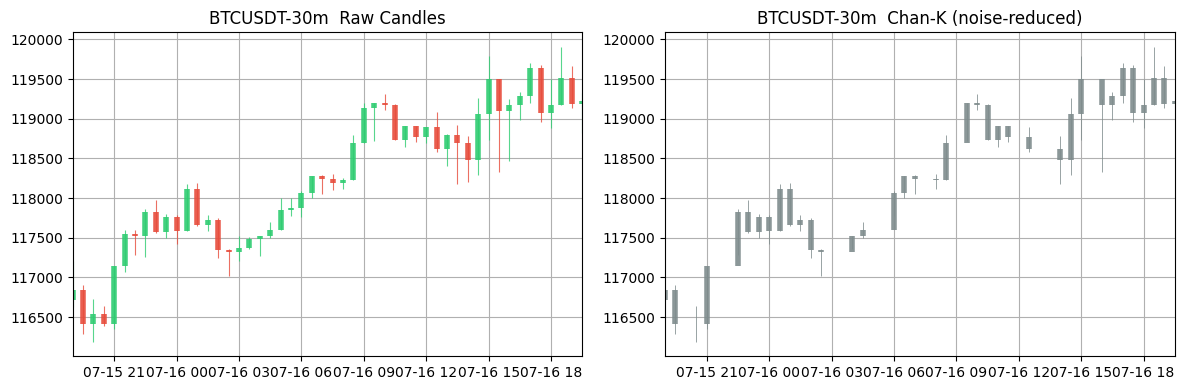

In [23]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def plot_candles(ax, df, color_up="#2ecc71", color_dn="#e74c3c", lw=0.8):
    for _, r in df.iterrows():
        o,h,l,c = float(r["open"]), float(r["high"]), float(r["low"]), float(r["close"])
        t = r["timestamp"]
        col = color_up if c>=o else color_dn
        ax.vlines(t, l, h, linewidth=lw, color=col, alpha=0.8)
        ax.vlines(t, min(o,c), max(o,c), linewidth=4.0, color=col, alpha=0.9)

fig, axes = plt.subplots(1,2, figsize=(12,4), sharex=False)

ax = axes[0]
plot_candles(ax, k_win)
ax.set_title(f"{sym}-{tf}  Raw Candles")
ax.grid(True)

ax = axes[1]
plot_candles(ax, ck_win, color_up="#7f8c8d", color_dn="#7f8c8d", lw=0.7)
ax.set_title(f"{sym}-{tf}  Chan-K (noise-reduced)")
ax.grid(True)

for ax in axes: ax.set_xlim(k_win["timestamp"].iloc[0], k_win["timestamp"].iloc[-1])

plt.tight_layout()
plt.show()

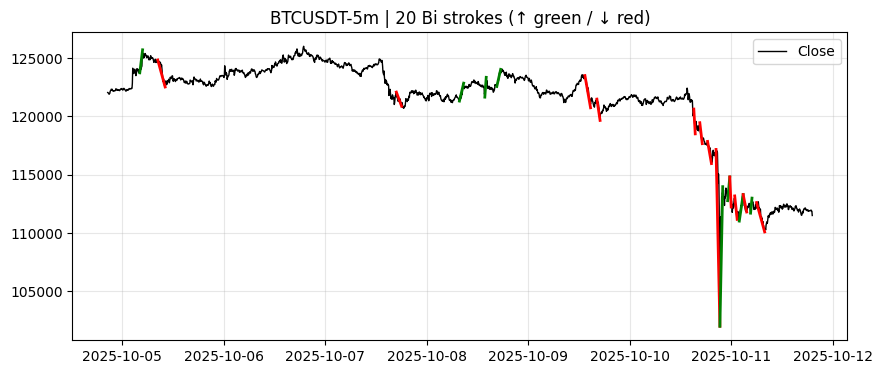

In [26]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

ROOT = Path("/Users/cc/PycharmProjects/ChanLab")
CHAN = ROOT / "chan_data"

def plot_bi(sym="BTCUSDT", tf="15m", n=200):
    p_k = ROOT / "DATA" / sym / f"{tf}.csv"
    p_bi = CHAN / "bi" / sym / f"{tf}_bi.csv"

    df_k = pd.read_csv(p_k)
    df_bi = pd.read_csv(p_bi)

    df_k["timestamp"] = pd.to_datetime(df_k["timestamp"], utc=True, errors="coerce")
    df_bi["timestamp_start"] = pd.to_datetime(df_bi["timestamp_start"], utc=True, errors="coerce")
    df_bi["timestamp_end"] = pd.to_datetime(df_bi["timestamp_end"], utc=True, errors="coerce")

    df_k = df_k.tail(n)
    t0, t1 = df_k["timestamp"].min(), df_k["timestamp"].max()

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(df_k["timestamp"], df_k["close"], color="black", linewidth=1.0, label="Close")

    count = 0
    for _, r in df_bi.iterrows():
        if not (t0 <= r["timestamp_end"] <= t1):
            continue
        color = "green" if r["dir"] == 1 else "red"
        ax.plot([r["timestamp_start"], r["timestamp_end"]],
                [r["start_price"], r["end_price"]],
                color=color, linewidth=2.0)
        count += 1

    ax.set_title(f"{sym}-{tf} | {count} Bi strokes (↑ green / ↓ red)")
    ax.grid(True, alpha=0.3)
    ax.legend(loc="best")
    plt.show()

plot_bi("BTCUSDT", "5m", n=2000)

In [8]:
def plot_window_no_chanK(sym, tf, left, right, save_dir=None, title_extra="", target_points=350):
    left, right = _as_utc(left), _as_utc(right)

    k   = _read_k(sym, tf)
    seg = _read_segments(sym, tf)
    zs  = _read_zs(sym, tf)
    mmd = _read_mmd(sym, tf)

    if k.empty:
        print(f"[WARN] no K to plot: {sym}-{tf}")
        return None

    k_win  = k[(k["timestamp"]>=left) & (k["timestamp"]<=right)].copy()
    seg_win = seg[(seg["timestamp_end"]>=left) & (seg["timestamp_start"]<=right)].copy() if not seg.empty else seg
    zs_win  = zs[(zs["timestamp_end"]>=left) & (zs["timestamp_start"]<=right)].copy() if not zs.empty else zs
    mmd_win = mmd[(mmd["ts"]>=left) & (mmd["ts"]<=right)].copy() if not mmd.empty else mmd

    def _downsample(df, max_points):
        if df is None or df.empty or len(df) <= max_points: return df
        idx = np.linspace(0, len(df)-1, max_points).round().astype(int)
        return df.iloc[idx]

    k_win_plot = _downsample(k_win, target_points)

    fig, ax = plt.subplots(figsize=(12, 5))

    ax.plot(
        k_win_plot["timestamp"],
        k_win_plot["close"],
        linewidth=1.2, alpha=0.9,
        label="close"
    )

    if not seg_win.empty:
        seg_win = seg_win.copy()
        seg_win["timestamp_start"] = pd.to_datetime(seg_win["timestamp_start"], utc=True, errors="coerce")
        seg_win["timestamp_end"]   = pd.to_datetime(seg_win["timestamp_end"],   utc=True, errors="coerce")

        prices = k[["timestamp","close"]].sort_values("timestamp").rename(columns={"timestamp":"t"})
        seg_win = pd.merge_asof(seg_win.sort_values("timestamp_start"),
                                prices.rename(columns={"t":"timestamp_start","close":"p_start"}),
                                on="timestamp_start", direction="nearest")
        seg_win = pd.merge_asof(seg_win.sort_values("timestamp_end"),
                                prices.rename(columns={"t":"timestamp_end","close":"p_end"}),
                                on="timestamp_end", direction="nearest")

        if ("direction" not in seg_win.columns) or seg_win["direction"].isna().all():
            seg_win["direction"] = np.where(seg_win["p_end"] >= seg_win["p_start"], "UP", "DN")

        cmap = {"UP": "#00C853", "DN": "#D50000"}
        for _, r in seg_win.iterrows():
            L, R = r["timestamp_start"], r["timestamp_end"]
            pL, pR = float(r.get("p_start", np.nan)), float(r.get("p_end", np.nan))
            col = cmap.get(str(r["direction"]).upper(), "#607D8B")  # 默认灰

            ax.axvspan(L, R, alpha=0.06, color=col)

            if np.isfinite(pL) and np.isfinite(pR):
                ax.plot([L, R], [pL, pR], color=col, linewidth=2.2)
                ax.scatter([L, R], [pL, pR], s=18, color=col, zorder=3)

        ax.plot([], [], color=cmap["UP"], linewidth=2.2, label="segment ↑ (UP)")
        ax.plot([], [], color=cmap["DN"], linewidth=2.2, label="segment ↓ (DN)")

    if (not zs_win.empty) and ("zs_low" in zs_win.columns) and ("zs_high" in zs_win.columns):
        for _, r in zs_win.iterrows():
            L, R = pd.to_datetime(r["timestamp_start"]), pd.to_datetime(r["timestamp_end"])
            ax.hlines([float(r["zs_low"]), float(r["zs_high"])],
                      xmin=L, xmax=R, linestyles="dotted", alpha=0.7)
        ax.plot([], [], linestyle="dotted", color="gray", label="ZS band")

    if not mmd_win.empty:
        buys  = mmd_win[mmd_win["side"]=="buy"]
        sells = mmd_win[mmd_win["side"]=="sell"]
        if not buys.empty:
            ax.scatter(
                buys["ts"], buys["price"],
                marker="^", s=70,
                edgecolors="black", linewidths=0.5,
                label="Buy"
            )
        if not sells.empty:
            ax.scatter(
                sells["ts"], sells["price"],
                marker="v", s=70,
                edgecolors="black", linewidths=0.5,
                label="Sell"
            )
        if "score" in mmd_win.columns and not mmd_win["score"].isna().all():
            smax = mmd_win.loc[mmd_win["score"].idxmax()]
            ax.axvline(pd.to_datetime(smax["ts"]), color="k", alpha=0.6, linestyle="--", label="max score ts")

    ax.set_title(f"{sym}-{tf}  [{left} ~ {right}] {title_extra}")
    ax.grid(True); ax.legend(loc="best")
    fig.autofmt_xdate()

    if save_dir:
        save_dir = Path(save_dir); save_dir.mkdir(parents=True, exist_ok=True)
        out = save_dir / f"{sym}_{tf}_{left:%Y%m%d_%H%M}-{right:%Y%m%d_%H%M}_noChanK.png"
        plt.savefig(out, dpi=150, bbox_inches="tight")
        print(f"[SAVED] {out}")
    plt.show()


[SAVED] /Users/cc/PycharmProjects/ChanLab/chan_data/figs/demo/ETHUSDT_30m_20250712_0000-20250717_0000_noChanK.png


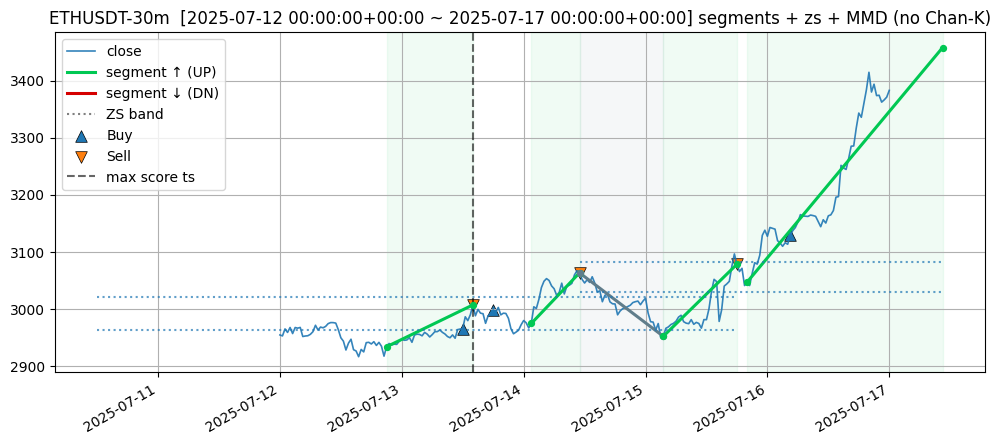

In [9]:
plot_window_no_chanK(
    "ETHUSDT", "30m",
    "2025-07-12 00:00", "2025-07-17 00:00",
    save_dir=CHAN/"figs"/"demo",
    title_extra="segments + zs + MMD (no Chan-K)",
    target_points=300
)

[SAVED] /Users/cc/PycharmProjects/ChanLab/chan_data/figs/demo/ETHUSDT_30m_20250712_0000-20250717_0000.png


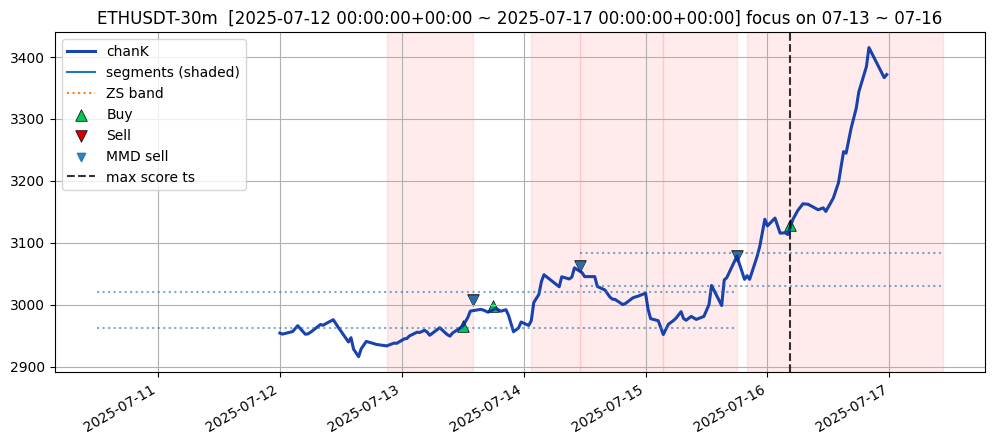

In [5]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ROOT = Path("/Users/cc/PycharmProjects/ChanLab")
CHAN = ROOT / "chan_data"
DATA = ROOT / "DATA"

def _as_utc(x):
    t = pd.to_datetime(x, errors="coerce")
    if hasattr(t, "tz") and t.tz is not None:
        return t.tz_convert("UTC")
    return t.tz_localize("UTC")

def _to_utc_series(s):
    t = pd.to_datetime(s, errors="coerce", utc=True)
    if getattr(t.dt, "tz", None) is None:
        t = t.dt.tz_localize("UTC")
    return t

def _read_k(sym, tf):
    p = DATA / sym / f"{tf}.csv"
    if not p.exists():
        print(f"[WARN] missing K: {p}")
        return pd.DataFrame(columns=["timestamp","open","high","low","close","volume"])
    df = pd.read_csv(p)
    df["timestamp"] = _to_utc_series(df["timestamp"])
    return df.dropna(subset=["timestamp"]).sort_values("timestamp").reset_index(drop=True)

def _read_chanK(sym, tf):
    p = CHAN / f"{sym}/{tf}_chanK.csv"
    if not p.exists():
        print(f"[WARN] missing chanK: {p}")
        return pd.DataFrame(columns=["timestamp","close"])
    df = pd.read_csv(p)
    col_ts = "timestamp" if "timestamp" in df.columns else ("ts" if "ts" in df.columns else None)
    if col_ts is None:
        return pd.DataFrame(columns=["timestamp","close"])
    df["timestamp"] = _to_utc_series(df[col_ts])
    if "close" not in df.columns and "price" in df.columns:
        df = df.rename(columns={"price": "close"})
    return df.dropna(subset=["timestamp"]).sort_values("timestamp").reset_index(drop=True)

def _read_segments(sym, tf):
    p = CHAN / "segments" / "fast" / sym / f"{tf}_segments.csv"
    if not p.exists():
        print(f"[WARN] missing segments: {p}")
        return pd.DataFrame(columns=["timestamp_start","timestamp_end","direction"])
    df = pd.read_csv(p)
    df["timestamp_start"] = _to_utc_series(df["timestamp_start"])
    df["timestamp_end"]   = _to_utc_series(df["timestamp_end"])
    return df.sort_values("timestamp_start").reset_index(drop=True)

def _read_zs(sym, tf):
    p = CHAN / "zhongshu_hierarchy_fast" / sym / f"{tf}_L1.csv"
    if not p.exists():
        print(f"[WARN] missing zs: {p}")
        return pd.DataFrame(columns=["timestamp_start","timestamp_end","zs_low","zs_high"])
    df = pd.read_csv(p)
    if "timestamp_start" not in df.columns and "start" in df.columns:
        df = df.rename(columns={"start":"timestamp_start"})
    if "timestamp_end" not in df.columns and "end" in df.columns:
        df = df.rename(columns={"end":"timestamp_end"})
    for c in ("zs_low","zs_high"):
        if c not in df.columns: df[c] = np.nan
    df["timestamp_start"] = _to_utc_series(df["timestamp_start"])
    df["timestamp_end"]   = _to_utc_series(df["timestamp_end"])
    return df.sort_values("timestamp_start").reset_index(drop=True)

def _read_mmd(sym, tf):
    p = CHAN / "signals" / "mmd" / sym / f"{tf}_mmd123.csv"
    if not p.exists():
        print(f"[WARN] missing mmd: {p}")
        return pd.DataFrame(columns=["ts","side","tag","price","score","ref_ts","ref_price"])
    df = pd.read_csv(p)
    if "ts" not in df.columns and "timestamp" in df.columns:
        df = df.rename(columns={"timestamp":"ts"})
    df["ts"] = _to_utc_series(df["ts"]) if "ts" in df.columns else pd.Series(dtype="datetime64[ns, UTC]")
    if "ref_ts" in df.columns:
        df["ref_ts"] = _to_utc_series(df["ref_ts"])
    return df.sort_values("ts").reset_index(drop=True)

def plot_window(sym, tf, left, right, save_dir=None, title_extra="", target_points=350):
    left, right = _as_utc(left), _as_utc(right)
    k   = _read_k(sym, tf)
    ck  = _read_chanK(sym, tf)
    seg = _read_segments(sym, tf)
    zs  = _read_zs(sym, tf)
    mmd = _read_mmd(sym, tf)

    if k.empty:
        print(f"[WARN] no K to plot: {sym}-{tf}")
        return None

    mask_k   = (k["timestamp"]>=left) & (k["timestamp"]<=right)
    ck_win   = ck[(ck["timestamp"]>=left) & (ck["timestamp"]<=right)].copy() if not ck.empty else ck
    seg_win  = seg[(seg["timestamp_end"]>=left) & (seg["timestamp_start"]<=right)].copy() if not seg.empty else seg
    zs_win   = zs[(zs["timestamp_end"]>=left) & (zs["timestamp_start"]<=right)].copy() if not zs.empty else zs
    mmd_win  = mmd[(mmd["ts"]>=left) & (mmd["ts"]<=right)].copy() if not mmd.empty else mmd

    def _downsample(df, max_points):
        if df is None or df.empty or len(df) <= max_points: return df
        idx = np.linspace(0, len(df)-1, max_points).round().astype(int)
        return df.iloc[idx]

    k_win_plot  = _downsample(k_win,  target_points)
    ck_win_plot = _downsample(ck_win, max(50, target_points//2))

    fig, ax = plt.subplots(figsize=(12, 5))
    if not ck_win_plot.empty:
        ax.plot(
            ck_win_plot["timestamp"],
            ck_win_plot["close"],
            linewidth=2.2,
            alpha=0.9,
            color="#002FA7",
            label="chanK"
        )

    if not seg_win.empty:
        for _, r in seg_win.iterrows():
            L, R = pd.to_datetime(r["timestamp_start"]), pd.to_datetime(r["timestamp_end"])
            ax.axvspan(L, R, alpha=0.08, color="red")
        ax.plot([], [], label="segments (shaded)")

    if not zs_win.empty and ("zs_low" in zs_win.columns) and ("zs_high" in zs_win.columns):
        for _, r in zs_win.iterrows():
            L, R = pd.to_datetime(r["timestamp_start"]), pd.to_datetime(r["timestamp_end"])
            ax.hlines([float(r["zs_low"]), float(r["zs_high"])], xmin=L, xmax=R, linestyles="dotted", alpha=0.6)
        ax.plot([], [], linestyle="dotted", label="ZS band")

    # MMD
        if not mmd_win.empty:
            buys  = mmd_win[mmd_win["side"]=="buy"]
            sells = mmd_win[mmd_win["side"]=="sell"]
            if not buys.empty:
                ax.scatter(
                buys["ts"], buys["price"],
                marker="^",
                color="#00C853",
                s=70,
                edgecolors="black",
                linewidths=0.5,
                label="Buy"
                )
            if not sells.empty:
                ax.scatter(
                    sells["ts"], sells["price"],
                    marker="v",
                    color="#D50000",
                    s=70,
                    edgecolors="black",
                    linewidths=0.5,
                    label="Sell"
                )
        if not sells.empty: ax.scatter(sells["ts"], sells["price"], marker="v", alpha=0.9, label="MMD sell")
        if "score" in mmd_win.columns and not mmd_win["score"].isna().all():
            smax = mmd_win.sort_values("score").iloc[-1]
            ax.axvline(pd.to_datetime(smax["ts"]), color="k", alpha=0.8, linestyle="--", label="max score ts")

    ax.set_title(f"{sym}-{tf}  [{left} ~ {right}] {title_extra}")
    ax.grid(True)
    ax.legend(loc="best")
    fig.autofmt_xdate()

    if save_dir:
        save_dir = Path(save_dir); save_dir.mkdir(parents=True, exist_ok=True)
        out = save_dir / f"{sym}_{tf}_{left:%Y%m%d_%H%M}-{right:%Y%m%d_%H%M}.png"
        plt.savefig(out, dpi=150, bbox_inches="tight")
        print(f"[SAVED] {out}")
    plt.show()

plot_window(
    "ETHUSDT", "30m",
    "2025-07-12 00:00", "2025-07-17 00:00",
    save_dir=CHAN/"figs"/"demo",
    title_extra="focus on 07-13 ~ 07-16",
    target_points=250
)
